In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [3]:
file=pd.read_csv(path+'/datasets/exchange_rate.csv')
del file['China']
data=(file-file[:-2000].min())/(file[:-2000].max()-file[:-2000].min())
scale=[file[:-2000].max().tolist(),file[:-2000].min().tolist()]
data1=data.values
scale

[[1.023657,
  2.109,
  1.091524,
  1.1097549999999998,
  0.012671,
  0.81635,
  0.7898890000000001],
 [0.483297, 1.372313, 0.618582, 0.548617, 0.006254, 0.393153, 0.523834]]

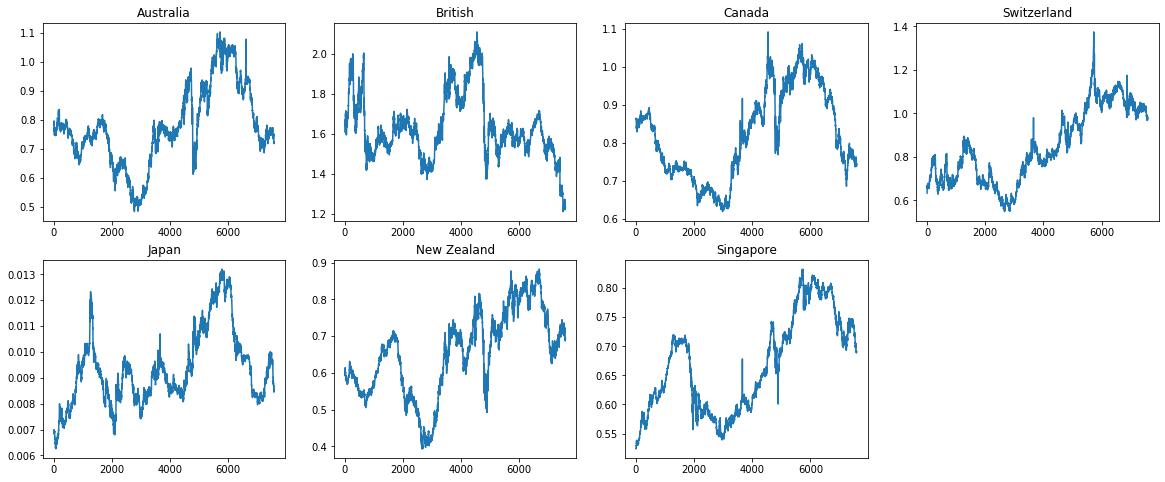

In [4]:
plt.figure(figsize=(20,8))
for i in range(len(file.columns)):
    plt.subplot(241+i)
    plt.plot(file[file.columns[i]])
    plt.title(file.columns[i])

# generate inputs and outputs

In [4]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors

    

def make_io(input_len,output_len,neighbors,split_size,shuffle=True):
    #neighbors should be a list where neighbors[0] is the target
    
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
    data_len=data1.shape[0]
    data_dim=data1.shape[1]

    
    
    for j in range(data_len-input_len-output_len):
        one_x=[]
        one_y=[]
        i=neighbors[0]
        s=[scale[0][i],scale[1][i]]
        for k in neighbors:
                one_x.append(data1[j:j+input_len,k].reshape(input_len,-1))
                one_y.append(data1[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
        one_x=np.concatenate(one_x,axis=1)
        one_y=np.concatenate(one_y,axis=1)
        one_data=[one_x.tolist(),one_y.tolist(),s]
            
        if j<(data_len-split_size):
            dataset1.append(one_data)
        else:
            dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


# training function

In [5]:
def train(inputs, epochs, input_dim, input_len, output_len, split, model, loss_func, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(data.columns[target])
    
    
    dataset1,dataset2=make_io(input_len,output_len,inputs,split)
    dataset3,dataset4=make_io(input_len,output_len,inputs,split,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,data.columns[target], target, 
                     scale, path+ '/results/plots/exchange_rate/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, X_test_valid
    

# Set gpu and loss functions

In [6]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


In [7]:
importlib.reload(util)

<module 'src.util' from '/media/data/home/darcy/master_summary/src/util.py'>

# train models

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 40, batch_first=True)
    (fc1): Linear(in_features=40, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Singapore
number of parmeters: 5973
epoch:0
training mae loss:0.6292740106582642
testing mae loss:1.132093071937561
testing mape:0.38901076
epoch:100
training mae loss:0.033527337945997715
testing mae loss:0.04230223968625069
testing mape:0.014556546
epoch:200
training mae loss:0.03

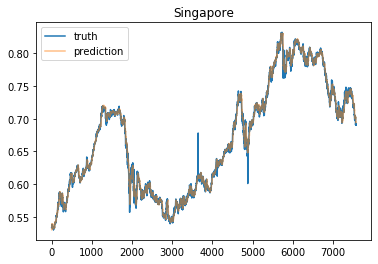

<Figure size 432x288 with 0 Axes>

In [11]:
import src.model


targets=[6]
input_dim=7
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=14
output_length=7

split=2000
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length)
    print(model)
    
    X_train,X_test=train(inputs,num_epochs,input_dim, input_length, output_length, split, model, objective)
    
    # plot_attention(model, X_train, X_test, column_names, neighbors, save_path)
    #attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')

    
    torch.save(model, path+ '/results/models/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

# show result

In [12]:
i=6
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+file_name+'.pt')

In [13]:
inputs=make_neighbor_list(target=i, input_dim=7)

dataset1, dataset2=make_io(input_len=14,output_len=7,neighbors=inputs, split_size=2000, shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

0.016680242
0.005806603


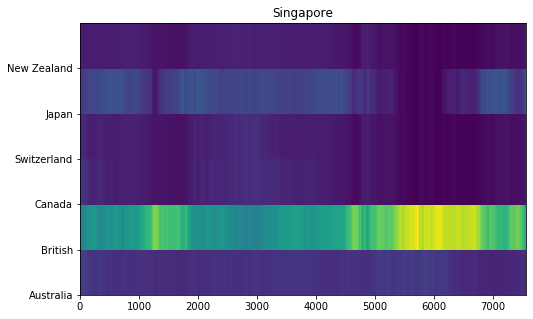

[[0.16793613135814667,
  0.35152995586395264,
  0.1375456303358078,
  0.11430995166301727,
  0.14666712284088135,
  0.0820111408829689],
 [0.16771847009658813,
  0.3520488142967224,
  0.1368713229894638,
  0.11381826549768448,
  0.14754091203212738,
  0.08200221508741379],
 [0.16727715730667114,
  0.3522338569164276,
  0.13633784651756287,
  0.11365657299757004,
  0.14832118153572083,
  0.0821734070777893],
 [0.16685324907302856,
  0.3528299033641815,
  0.13575029373168945,
  0.11331383138895035,
  0.1489410251379013,
  0.08231164515018463],
 [0.16653047502040863,
  0.35335463285446167,
  0.1353185623884201,
  0.11303006857633591,
  0.149329274892807,
  0.08243691176176071],
 [0.16595277190208435,
  0.35383349657058716,
  0.13481822609901428,
  0.1128133088350296,
  0.14994636178016663,
  0.08263590186834335],
 [0.16534996032714844,
  0.3542296886444092,
  0.13444854319095612,
  0.11257103085517883,
  0.1505793184041977,
  0.08282140642404556],
 [0.1646486520767212,
  0.354803979396820

<Figure size 432x288 with 0 Axes>

In [14]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')
attns